# Destabilize the page ranks

Jelle van den Brink, Tim Angevare

Take the three algorithms you know which will rank web pages based on link analysis: In- Degree, PageRank, and HITS. We would like to study whether or not each of these three ranking algorithms is stable.

In [329]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

This will be our template to fill and later calculate our score / rank data

In [330]:
data_template = {
'original' : {
    'hits' : {
      'scores' : [],
      'ranks' : []},
    'pagerank' : {
      'scores' : [],
      'ranks' : []},
    'indegree': {
      'scores' : [],
      'ranks' : []},
    },
'changed' : {
    'hits' : {
      'scores' : [],
      'ranks' : []},
    'pagerank' : {
      'scores' : [],
      'ranks' : []},
    'indegree': {
      'scores' : [],
      'ranks' : []}
    }
}

Below are our pre made directed graphs we want to test

In [331]:
graphs_to_test = {
    "arrow" : [(1,2), (2,3), (3,4), (4,5), (5,6), (6,7), (7,8), (8,9), (9,10), (10,11), (11,12), (12,13), (13,14), (14,15)],
    "double_lasso" : [(1,2), (2,1), (2,3), (3,2), (3,4), (4,3), (4,5), (5,4), (5,6), (6,5), (6,1), (1,6), (4,7), (7,8), (8,9), (9,10), (1,11), (11,12), (12,13), (13,14)],
    "inward_star": [(2,1), (3,1), (4,1), (5,1), (6,1), (7,1), (8,1), (9,1), (10,1), (11,1), (12,1), (13,1), (14,1)],
    "directed_grid": [(1,2), (1,4), (2,3), (2,5), (3,6), (4,5), (4,7), (5,6), (5,8), (6,9), (7,8), (8,9), (3,10), (10,11), (6,11), (11,12), (9,12), (12,13), (7,16), (16,15), (8,15), (15,14), (9,14), (14,13)],
    "high_score": [(2,3), (3,2), (4,1), (4,2), (5,2), (5,6), (5,4), (6,5), (6,2), (7,2), (7,5), (8,2), (8,5), (9,2), (9,5), (10,5), (11,5)],
    "circles": [(1,2), (2,3), (3,4), (4,5), (5,6), (6,7), (7,1), (8,9), (9,10), (10,11), (11,12), (12,13), (13,14), (14,8), (4,8), (8,4)]}

A generic function copied over from week 2 project. This takes an list of scores and sorts them according to rank.

In [332]:
def rank_list_values(li):
  li_copy = li.copy()
  copied = sorted(li_copy, reverse=True)
  res = [0 for i in range(len(li_copy))]

  i = 0
  while sum([1 if x >= 0 else 0 for x in li_copy]) > 0:
    val = copied[i]
    original_i = li_copy.index(val)
    res[original_i] = i + 1
    li_copy[original_i] = -1
    i += 1

  return res

HITS algorithm function taken from week 2 project. Takes a matrix along with a k and beta value as the function's arguments

In [333]:
def hits(matrix, k=10, beta=0.85):
  #This is the main function. it gets a generated matrix and uses the HITS algorithm to calculate the scores
  hub_vector = np.ones([len(matrix), 1])
  transpose = np.transpose(matrix)

  for i in range(k):
    authority_vector = np.matmul(transpose, hub_vector) * beta
    authority_vector /= np.sum(authority_vector)

    hub_vector = np.matmul(matrix, authority_vector) * beta
    hub_vector /= np.sum(hub_vector)

  added = np.add(authority_vector, hub_vector).flatten().tolist()
  return added

PageRank algorithm function taken from week 2 project. Takes a matrix along with a k and beta value as the function's arguments

In [334]:
def page_rank(matrix, beta=0.85, k=50):
  num_nodes = matrix.shape[0]
  pr_scores = np.ones(num_nodes) / num_nodes

  for i in range(k):
    new_pr_scores = beta * np.dot(matrix, pr_scores) + (1 - beta) / num_nodes

    if np.allclose(pr_scores, new_pr_scores):
      break

    pr_scores = new_pr_scores

  return pr_scores.flatten().tolist()

In-Degree algorithm function taken from week 2 project. Takes a matrix along with a k and beta value as the function's arguments

In [335]:
def indegree(graph):
  scores=[]
  destinations=[]
  #Gets al the destination nodes from the edges and counts the occurences per node
  for edge in graph.edges():
    destinations.append(edge[1])
  for node in graph.nodes():
    scores.append(destinations.count(node))

  return scores

A genereic function copied from the week 2 project. The function was used to calculate the difference between two ranking algorithms. Here it will be used to calculate to calculate the difference between two ranking vectors before and after change.

In [336]:
def calc_distance(v1, v2):
  nums_abs = []
  for i in range(len(v1)):
    nums_abs.append(abs(v1[i] - v2[i]))
  return sum(nums_abs)

This function will take two lists of ranks and return the max rank difference for an index

In [337]:
def biggest_rank_change(list1, list2):
    changes = [abs(a - b) for a, b in zip(list1, list2)]
    return max(changes)

Given the origanal graph and a certain size this function will change the original graph. With p 0.5 we want to either add a new edge or remove an existing one.

In [338]:
def change_graph(graph : nx.DiGraph, size : int, show_graphs : bool):
  changed_graph = graph.copy()
  nodes = list(graph.nodes)

  for i in range(size):
    ran_int = randint(0,1)
    if ran_int == 0:
      while True:
        ran_from = nodes[randint(0,len(nodes) - 1)]
        ran_to = nodes[randint(0,len(nodes) - 1)]
        if ran_from != ran_to:
          break
      changed_graph.add_edge(ran_from, ran_to)
    else:
      edges = list(graph.edges)
      while True:
        ran_edge = edges[randint(0,len(edges) - 1)]
        if ran_edge in list(changed_graph.edges):
          changed_graph.remove_edge(ran_edge[0], ran_edge[1])
          break
    if show_graphs:
      nx.draw(changed_graph, with_labels=True)
      plt.title(graph.graph['name'] + ' with k of ' + str(size))
      plt.show()
    return changed_graph



Given a name of the graphs to test this function will generate a directed graph object.

In [339]:
def gen_graph(name : str):
  graph = nx.DiGraph(graphs_to_test[name], name=name)
  nx.draw(graph, with_labels=True)
  plt.title('Original of ' + name)
  plt.show()
  return graph

This function with fill in the scores of the various algorithms given a directed graph.

In [340]:
def fillScores(metrics_graph, graph : nx.DiGraph):
  matrix = nx.to_numpy_array(graph)
  hits_score = hits(matrix)
  metrics_graph['hits']['scores'].append(hits_score)

  page_rank_score = page_rank(matrix)
  metrics_graph['pagerank']['scores'].append(page_rank_score)

  indegree_score = indegree(graph)
  metrics_graph['indegree']['scores'].append(indegree_score)

Here we calculate the avarage given an amount f n list for each iteration. the result is one list with the average of all. This will allow us to get the most trustworth scores for a k size change

In [341]:
def calc_average_scores(metrics_graph, runs: int):
    for algorithm in metrics_graph.keys():
      avg_scores = []
      for i in range(len(metrics_graph[algorithm]['scores'][0])):
        total = sum([metrics_graph[algorithm]['scores'][run][i] for run in range(runs)])
        avg_scores.append(total / runs)
      metrics_graph[algorithm]['scores'] = []
      metrics_graph[algorithm]['scores'].append(avg_scores)

Using the average of the scores we can calculate the ranks of each algorithm

In [342]:
def calc_ranks(metrics_graph):
  for graph in metrics_graph.keys():
    for algorithm in metrics_graph[graph].keys():
      ranks = rank_list_values(metrics_graph[graph][algorithm]['scores'][0])
      metrics_graph[graph][algorithm]['ranks'] = ranks

This function is responsible for given an original graph and a value k (size), to create a changed graph and calculate the avarage scores as well as the ranks.

In [343]:
def calc_effect_change(graph: nx.DiGraph, size: int, show_graphs: bool, runs: int):
  metrics = data_template.copy()
  fillScores(metrics['original'], graph)
  for _ in range(runs):
    changed_graph = change_graph(graph, size, show_graphs)
    fillScores(metrics['changed'], changed_graph)
  calc_average_scores(metrics['changed'], runs)
  calc_ranks(metrics)
  return metrics

Here we create the two line graphs using our summaritive data and range of k values.

In [344]:
def create_graphs(summaritive_data, k_values, name):
  for algorithm in summaritive_data.keys():
    plt.plot(k_values,summaritive_data[algorithm]['absolute_changes'], label=algorithm)
  plt.legend()
  plt.title('Total change of ranks in graph ' + name)
  plt.ylabel('sum in difference of ranks')
  plt.xlabel('values of k')
  plt.xticks(k_values)
  plt.show()

  for algorithm in summaritive_data.keys():
     plt.plot(k_values,summaritive_data[algorithm]['max_rank_changes'], label=algorithm)
  plt.title('Maximum change in rank for a node in graph ' + name)
  plt.ylabel('change in rank')
  plt.xlabel('values of k')
  plt.xticks(k_values)
  plt.legend()
  plt.show()

This is our main function responsible for combining every aspact of the code. It takes a graph name, a range for k and a value for the amount of runs to do for each k value.

In [345]:
def main(graph: str, k_from: int, k_to: int, show_graphs: bool, runs: int):
  #summaritive data to fill with the statistics of the ranks
  summaritive_data = {
    'hits' : {
        'absolute_changes' : [],
        'max_rank_changes' : []},
    'pagerank' : {
        'absolute_changes' : [],
        'max_rank_changes' : []},
    'indegree' : {
        'absolute_changes' : [],
        'max_rank_changes' : []}}
  #k value ranks
  k_values = []
  generate_from_str = gen_graph(graph)
  # loop over k range
  for k in range(k_from, k_to + 1):
    k_values.append(k)
    # calc the change with a changed graph compared to original
    data = calc_effect_change(generate_from_str, k, show_graphs, runs)
    # for each algorithm calculate the statistics
    for algorithm in summaritive_data.keys():

      summaritive_data[algorithm]['absolute_changes'].append(
          calc_distance(data['original'][algorithm]['ranks'],
                        data['changed'][algorithm]['ranks']))

      summaritive_data[algorithm]['max_rank_changes'].append(
          biggest_rank_change(data['original'][algorithm]['ranks'],
                              data['changed'][algorithm]['ranks']))
  #finally create and show the graphs
  create_graphs(summaritive_data, k_values, graph)

An example of how the code function with the "double lasso" pre made test graph.

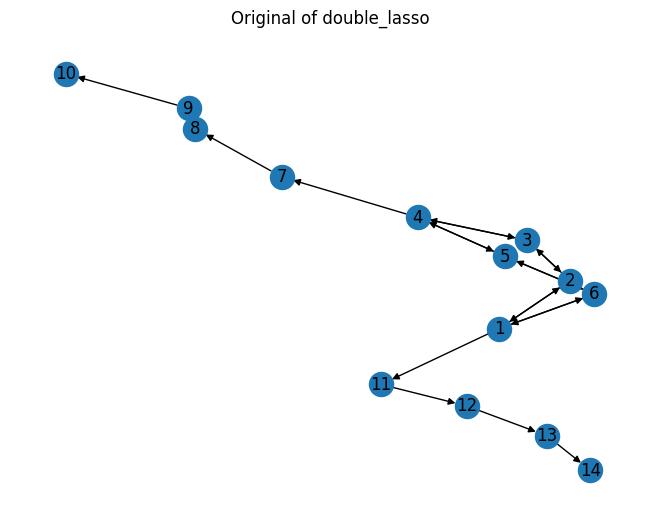

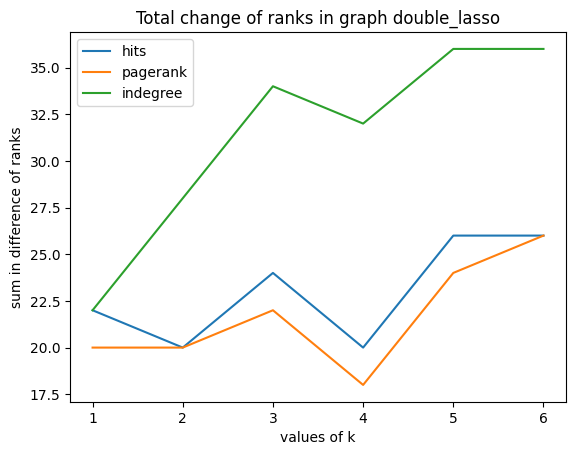

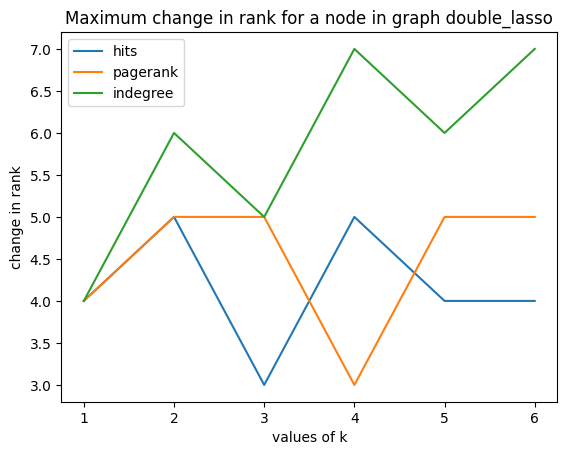

In [346]:
main(graph="double_lasso", k_from=1, k_to=6, show_graphs=False, runs=5)